_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Pretraining

The `capa_intermittency.dat` feeds the model with the dynamics of the Capacitor

In [3]:
data = np.genfromtxt('capa_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,0]

## Computing the Gradient

_Calculating the value of_ $\frac{dx}{dt}$

In [4]:
t_diff = 1
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:] # dx/dt
print(gradient_t)

1.0
1        0.000298
2        0.000298
3        0.000297
4        0.000297
5        0.000297
           ...   
9996     0.000018
9997     0.000018
9998     0.000018
9999     0.000018
10000    0.000018
Name: 0, Length: 10000, dtype: float64


## Loading Datasets

In [5]:
data = pd.read_csv("c8_interpolated_2250_100.csv")
training_set = data.iloc[:, 1]
training_set

0       88.200000
1       87.987115
2       87.774230
3       87.561345
4       87.348459
          ...    
2345    56.688809
2346    56.679791
2347    56.670773
2348    56.661754
2349    56.652736
Name: C8, Length: 2350, dtype: float64

In [6]:
test = training_set.tail(100)
test
training_set = training_set.head(2250)
training_set

0       88.200000
1       87.987115
2       87.774230
3       87.561345
4       87.348459
          ...    
2245     1.227377
2246     0.677593
2247     0.452216
2248     0.000000
2249     0.857867
Name: C8, Length: 2250, dtype: float64

In [7]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
print(gradient_t)

0       0.000298
1       0.000298
2       0.000297
3       0.000297
4       0.000297
          ...   
9995    0.000018
9996    0.000018
9997    0.000018
9998    0.000018
9999    0.000018
Name: 0, Length: 10000, dtype: float64


In [8]:
df = pd.concat((training_set, gradient_t), axis=1)
df.columns = ['y_t', 'grad_t']

In [9]:
df

,y_t,grad_t
0,88.200000,0.000298
1,87.987115,0.000298
2,87.774230,0.000297
3,87.561345,0.000297
4,87.348459,0.000297
...,...,...
9995,NaN,0.000018
9996,NaN,0.000018
9997,NaN,0.000018
9998,NaN,0.000018


## Plot of the External Forcing from Chaotic Differential Equation

<Axes: >

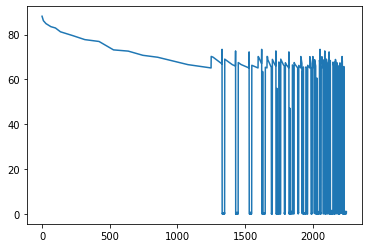

In [10]:
df.iloc[:, 0].plot()

C:\Users\Anurag Dutta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

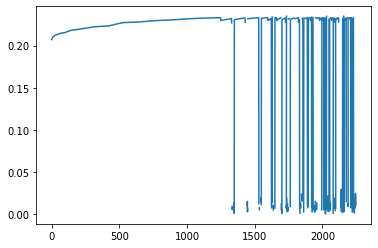

In [11]:
import numpy as np
c0 = 85.7336  # Value for C0
K0 = -0.0020  # Value for K0
K1 = 0.0002  # Value for K1
a = 0.0000    # Value for a
b = 0.0125    # Value for b
c = 2.3008    # Value for c

L = np.minimum(c0, (df.iloc[:, 1] - (df.iloc[:, 0] * (K0 - K1 * (9 * a * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c)**2 + 4 * b * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c) + c)))))
L.plot()

## Preprocessing the data into supervised learning

In [12]:
# split a sequence into samples
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n_in, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n_out)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg

In [13]:
data = Supervised(df.values, n_in = 350, n_out = 100)


cols_to_drop = []
for i in range(2, 351):
    cols_to_drop.extend([f'var2(t-{i})'])

data.drop(cols_to_drop, axis=1, inplace=True)

print(data.head())
print(data.columns)

     var1(t-350)  var1(t-349)  var1(t-348)  var1(t-347)  var1(t-346)  \
350    88.200000    87.987115    87.774230    87.561345    87.348459   
351    87.987115    87.774230    87.561345    87.348459    87.135574   
352    87.774230    87.561345    87.348459    87.135574    86.922689   
353    87.561345    87.348459    87.135574    86.922689    86.709804   
354    87.348459    87.135574    86.922689    86.709804    86.496919   

     var1(t-345)  var1(t-344)  var1(t-343)  var1(t-342)  var1(t-341)  ...  \
350    87.135574    86.922689    86.709804    86.496919    86.294538  ...   
351    86.922689    86.709804    86.496919    86.294538    86.221709  ...   
352    86.709804    86.496919    86.294538    86.221709    86.148880  ...   
353    86.496919    86.294538    86.221709    86.148880    86.076050  ...   
354    86.294538    86.221709    86.148880    86.076050    86.003221  ...   

     var1(t+95)  var2(t+95)  var1(t+96)  var2(t+96)  var1(t+97)  var2(t+97)  \
350   76.094351    0.0002

In [14]:
train = np.array(data[0:len(data)-1])
forecast = np.array(data.tail(1))

In [15]:
trainy = train[:,-300:]
trainX = train[:,:-300]

In [16]:
forecasty = forecast[:,-300:]
forecastX = forecast[:,:-300]

In [17]:
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
forecastX = forecastX.reshape((forecastX.shape[0], 1, forecastX.shape[1]))
print(trainX.shape, trainy.shape, forecastX.shape)

(1800, 1, 251) (1800, 300) (1, 1, 251)


In [18]:
C0 = tf.Variable(85.7336, name="C0", trainable=True, dtype=tf.float32)
K0 = tf.Variable(-0.0020, name="K0", trainable=True, dtype=tf.float32)
K1 = tf.Variable(-0.0002, name="K1", trainable=True, dtype=tf.float32)
a = tf.Variable(0.0000, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(0.0125, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(2.3008, name="c", trainable=True, dtype=tf.float32)

splitr = 0.8


def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    #squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    #squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    epsilon = 1
    squared_difference3 = tf.square(
        y_pred[:, 1] - (
            y_pred[:, 0] * (
                K0 - K1 * (
                    9 * a * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c)**2 +
                    4 * b * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c) + c
                )
            )
        )
    )
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(60))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(splitr*trainX.shape[0])], trainy[:int(splitr*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(splitr*trainX.shape[0]):trainX.shape[0]], trainy[int(splitr*trainX.shape[0]):trainX.shape[0]]), shuffle=False)

Epoch 1/500
23/23 [==============================] - 3s 24ms/step - loss: 4519.0015 - val_loss: 2455.1340
Epoch 2/500
23/23 [==============================] - 0s 4ms/step - loss: 4254.3589 - val_loss: 2328.8699
Epoch 3/500
23/23 [==============================] - 0s 5ms/step - loss: 4115.7241 - val_loss: 2266.8657
Epoch 4/500
23/23 [==============================] - 0s 7ms/step - loss: 4012.8694 - val_loss: 2211.5879
Epoch 5/500
23/23 [==============================] - 0s 6ms/step - loss: 3915.1719 - val_loss: 2159.4597
Epoch 6/500
23/23 [==============================] - 0s 6ms/step - loss: 3821.5552 - val_loss: 2110.2563
Epoch 7/500
23/23 [==============================] - 0s 5ms/step - loss: 3732.1194 - val_loss: 2060.9651
Epoch 8/500
23/23 [==============================] - 0s 5ms/step - loss: 3636.4521 - val_loss: 2010.5308
Epoch 9/500
23/23 [==============================] - 0s 4ms/step - loss: 3545.1787 - val_loss: 1963.9191
Epoch 10/500
23/23 [==============================] - 

In [19]:
forecast_without_mc = forecastX
yhat_without_mc = model.predict(forecast_without_mc) # Step Ahead Prediction
forecast_without_mc = forecast_without_mc.reshape((forecast_without_mc.shape[0], forecast_without_mc.shape[2])) # Historical Input

1/1 [==============================] - 0s 440ms/step


In [20]:
forecastX.shape

(1, 1, 251)

In [21]:
forecast_without_mc.shape

(1, 251)

In [22]:
inv_yhat_without_mc = np.concatenate((forecast_without_mc, yhat_without_mc), axis=1) # Concatenation of predicted values with Historical Data
#inv_yhat_without_mc = scaler.inverse_transform(inv_yhat_without_mc) # Transform labels back to original encoding

In [23]:
inv_yhat_without_mc.shape

(1, 311)

In [24]:
fforecast = inv_yhat_without_mc[:,-300:]

In [25]:
fforecast.shape

(1, 300)

In [26]:
final_forecast = fforecast[:,0:300:3]

In [27]:
fforecast.shape

(1, 300)

In [28]:
# code to replace all negative value with 0
final_forecast[final_forecast<0] = 0

In [29]:
final_forecast

array([[6.61120098e+01, 6.58725140e+01, 6.56418067e+01, 6.54119160e+01,
        6.51820252e+01, 0.00000000e+00, 9.20709900e-01, 2.56794500e-01,
        2.82769000e-02, 4.86232900e-01, 0.00000000e+00, 0.00000000e+00,
        7.08772300e-01, 6.64668184e+01, 6.62273226e+01, 6.59788268e+01,
        0.00000000e+00, 8.07057600e-02, 6.72595588e+01, 6.68435924e+01,
        6.65643908e+01, 6.63248950e+01, 6.60853992e+01, 6.58459034e+01,
        6.56165966e+01, 6.53897059e+01, 6.51628151e+01, 0.00000000e+00,
        6.26430630e-01, 6.61829715e+01, 6.59434757e+01, 6.57090336e+01,
        6.54821429e+01, 6.52552521e+01, 7.00289449e+01, 6.88478058e+01,
        6.76139006e+01, 3.52500080e-01, 0.00000000e+00, 0.00000000e+00,
        6.55625610e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.07138500e-02, 1.02327240e-01, 0.00000000e+00, 6.54401261e+01,
        6.52132353e+01, 1.84284000e-01, 0.00000000e+00, 6.62361928e+01,
        6.59966970e+01, 6.57594538e+01, 6.55325630e+01, 6.530567

In [30]:
final_forecast.shape

(1, 100)

In [31]:
test.shape

(100,)

In [32]:
training_set = np.array(training_set)
test = np.array(test)
final_forecast = np.array(final_forecast.squeeze(0))

In [33]:
test

array([57.54554212, 57.53652388, 57.52750564, 57.51848739, 57.50946915,
       57.50045091, 57.49143267, 57.48241443, 57.47339619, 57.46437795,
       57.4553597 , 57.44634146, 57.43732322, 57.42830498, 57.41928674,
       57.4102685 , 57.40125026, 57.39223201, 57.38321377, 57.37419553,
       57.36517729, 57.35615905, 57.34714081, 57.33812257, 57.32910432,
       57.32008608, 57.31106784, 57.3020496 , 57.29303136, 57.28401312,
       57.27499488, 57.26597663, 57.25695839, 57.24794015, 57.23892191,
       57.22990367, 57.22088543, 57.21186719, 57.20284894, 57.1938307 ,
       57.18481246, 57.17579422, 57.16677598, 57.15775774, 57.1487395 ,
       57.13972125, 57.13070301, 57.12168477, 57.11266653, 57.10364829,
       57.09463005, 57.08561181, 57.07659356, 57.06757532, 57.05855708,
       57.04953884, 57.0405206 , 57.03150236, 57.02248412, 57.01346587,
       57.00444763, 56.99542939, 56.98641115, 56.97739291, 56.96837467,
       56.95935643, 56.95033818, 56.94131994, 56.9323017 , 56.92

In [34]:
test.shape

(100,)

In [35]:
final_forecast.shape

(100,)

In [36]:
test.shape

(100,)

In [37]:
import math
MSE = np.square(np.subtract(np.array(test),np.array(final_forecast))).mean()   
rsme = math.sqrt(MSE)
print(rsme)  
MAE = np.abs(np.subtract(np.array(test),np.array(final_forecast))).mean()   
mae = MAE
print(mae)

42.622774564783136
35.37679145460413
